In [1]:
image_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeA/220209_P36_N2_new/220209_P36_N2_FlipV_R255_clahe.tif'
mask_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeA/220209_P36_N2_new/220209_P36_N2_FlipV_R255_mask1.tif'
cols_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeA/220209_P36_N2_new/211121_P36.5_N1_R295_ColRois.zip'
save_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeA/output/'
save_name = '220209_P36_N2_new'

if save_path[-1] != '/':
    save_path += '/'

##
start_im = 2 ### index of the first timepoint to include (0 is the first)
start_age = 37
entry_point = (0,27,290,245) #entry point of the neuron (T,Z,Y,X), where Z=0
stab_limit = 5 #(No. of timepoints for stable branches calculation)
nor_fact = 1 #this is for normalizing Col_occpancy. for now there is no other option, like neuron max

if save_path[-1] != '/':
    save_path += '/'

In [2]:
#imports
import utils.analysis as analysis
import utils.test as test
import matplotlib.pyplot as plt
import tifffile as tif
import numpy as np
from tqdm import tqdm
import pandas as pd
from read_roi import read_roi_zip as col_zip

In [3]:
neuron = tif.imread(image_path)

In [4]:
# do this step if you want to mask your neuron
mask = tif.imread(mask_path)
neuron[mask==0] = 0

In [5]:
# make all images binary
neuron = neuron[start_im:]
neuron[neuron != 0] = 1
# Cols = Cols - Cols.min()
# Cols[Cols!=0] = 1 

In [6]:
Cols = col_zip(cols_path)
## you might want to subset either neuron, Columns or both
# neuron = neuron[:,:40]


In [6]:
lifetimes = analysis.cal_lifetimes(neuron, save=False, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)
stable_neuron = analysis.stable_N(lifetimes, stab_limit=stab_limit, save=False, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)
# in case you want to save the neuron
stable_neuron = stable_neuron.astype('uint16')
tif.imwrite(save_path+'stable'+save_name, stable_neuron, imagej=True, resolution=(1./0.076, 1./0.076),
                metadata={'spacing': 0.4, 'unit': 'um', 'finterval': 1/10,'axes': 'TZYX'})                                    
output_results = analysis.N_volume(neuron, stable_neuron, normalize=False, 
                                start_t=start_age, plot=False, 
                                save=False, save_path=save_path, 
                                save_file='Vol_'+save_name)
output_results['growthR_all'] = output_results.vol_all.diff()/output_results.vol_all
output_results['growthR_stable'] = output_results.vol_stable.diff()/output_results.vol_stable
output_results['trans_per'] = (output_results.vol_all - output_results.vol_stable)/output_results.vol_stable
DGIs = analysis.calculate_DGI(entry_point, neuron, 
                                start_t=start_age, 
                                save=True, save_path='', 
                                save_file='')
output_results = pd.merge(output_results, DGIs, on='timepoints')

100%|██████████| 86/86 [03:04<00:00,  2.14s/it]


In [7]:
in_col = np.zeros_like(neuron)
for col, Roi in Cols.items():
    masked_nD, Roi_3D = analysis.roi_img(neuron, Roi)
    in_col =  in_col + masked_nD
# out_col = neuron - in_col
output_results['size_in_cols'] = in_col.sum(axis=(1,2,3))
# output_results['size_out_cols'] = out_col.sum(axis=(1,2,3))

NameError: name 'Cols' is not defined

In [8]:
output_file = save_path+save_name+'_output.csv'
output_file = output_file.replace('.tif','')
output_results.to_csv(output_file, sep=';')

In [9]:
# calculate columns' occupancy
# define the neuron and saving name
cols_hist = analysis.col_occupancy(neuron, cols_zip=Cols, norm_cols=Cols, 
                                    normalize_cols=True, nor_fact=nor_fact, 
                                    start_t=start_age, 
                                    plot=True, save=True, 
                                    save_path=save_path, 
                                    save_file='all_px_'+save_name)

cols_hist = analysis.col_occupancy(stable_neuron, cols_zip=Cols, norm_cols=Cols, 
                                    normalize_cols=True, nor_fact=nor_fact, 
                                    start_t=start_age, 
                                    plot=True, save=True, 
                                    save_path=save_path, 
                                    save_file='stab_px_'+save_name)

NameError: name 'Cols' is not defined

In [11]:
output_results.head()

,timepoints,vol_all,vol_stable,growthR_all,growthR_stable,trans_per,ori_vec,Max_Vec_length,av_vect,av_vect_length,ori_vec_deg,deg_variance,DGI,y_spread,x_spread,size_in_cols
0,37.00,95313,0,NaN,NaN,inf,"[-474704, -2919527, -382696]",3.900664e+06,"[-4.980527110961893, -30.631263639415813, -4.0...",31.292199,191.796863,3867.012563,0.764619,155,86,64506
1,37.25,96316,0,1.041364e-02,NaN,inf,"[-484128, -3136678, -706532]",4.086979e+06,"[-5.026454586984509, -32.566531002118026, -7.3...",33.758772,195.272593,3147.780010,0.795578,151,79,67830
2,37.50,102673,0,6.191501e-02,NaN,inf,"[-461609, -3717958, -600445]",4.643584e+06,"[-4.495914213084258, -36.21164278826956, -5.84...",36.955337,191.514028,2844.491281,0.817109,154,81,72128
3,37.75,91071,0,2.025534e+14,NaN,inf,"[-429296, -3203460, -716324]",3.947302e+06,"[-4.713860614246028, -35.1754125901769, -7.865...",36.351026,194.611305,2107.790029,0.838680,150,89,63968
4,38.00,97465,56004,6.560304e-02,1.0,0.740322,"[-432422, -2526488, -630980]",3.814046e+06,"[-4.436735615201511, -25.922268735122714, -6.4...",27.084332,196.844521,4072.954509,0.692112,144,100,68513


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


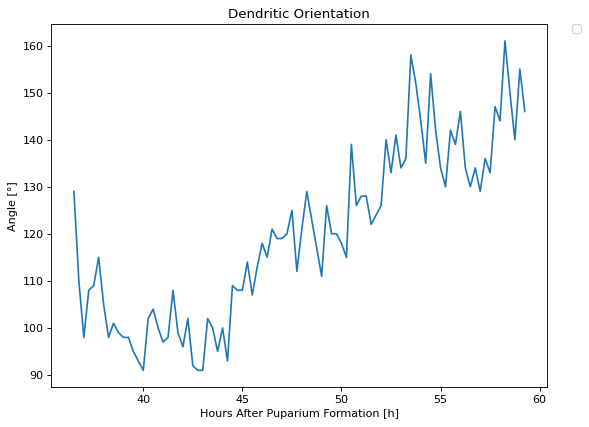

In [8]:
fig_name = save_path+save_name+'_y_spread.pdf'
plt.figure(figsize=(8, 6), dpi=80)
y = output_results.x_spread[:]
plt.plot(output_results.timepoints[:],y)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Dendritic Orientation')
plt.ylabel('Angle [°]')
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig(fig_name, bbox_inches='tight')

In [10]:
# run this if you already calculated stable_neuron
# stable_n = tif.imread(stable_path)

# or calculate stable pixels with the following command
lifetimes = analysis.cal_lifetimes(neuron, save=False, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)
stable_neuron = analysis.stable_N(lifetimes, stab_limit=stab_limit, save=False, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)

stable_neuron[stable_neuron !=0] = 1

# in case you want to save the neuron
stable_neuron = stable_neuron.astype('uint16')
tif.imwrite(save_path+'stable'+save_name, stable_neuron, imagej=True, resolution=(1./0.076, 1./0.076),
                metadata={'spacing': 0.4, 'unit': 'um', 'finterval': 1/10,'axes': 'TZYX'})

100%|██████████| 92/92 [00:04<00:00, 22.43it/s]


In [6]:
# stable_neuron[stable_neuron !=0] = 1
# transient = neuron - stable_neuron
# tif.imwrite(save_path+'trans'+save_name, transient, imagej=True, resolution=(1./0.076, 1./0.076),
#                 metadata={'spacing': 0.4, 'unit': 'um', 'finterval': 1/10,'axes': 'TZYX'})

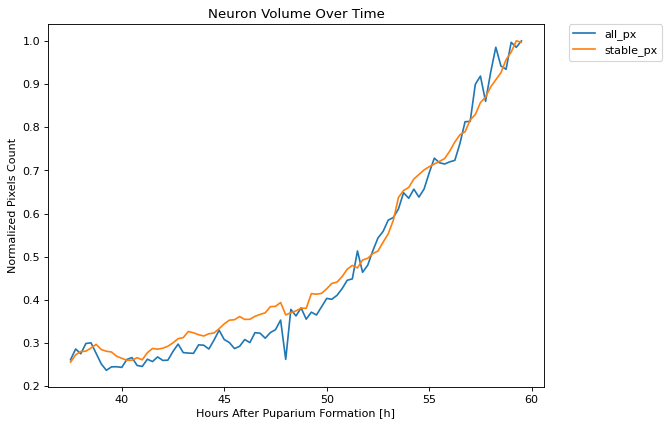

In [9]:
fig_name = save_path+save_name+'_Volume.pdf'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(output_results.timepoints[4:],output_results.vol_all[4:]/output_results.vol_all.max(), label='all_px')
plt.plot(output_results.timepoints[4:],output_results.vol_stable[4:]/output_results.vol_stable.max(), label='stable_px')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Neuron Volume Over Time')
plt.ylabel('Normalized Pixels Count')
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig(fig_name, bbox_inches='tight')




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


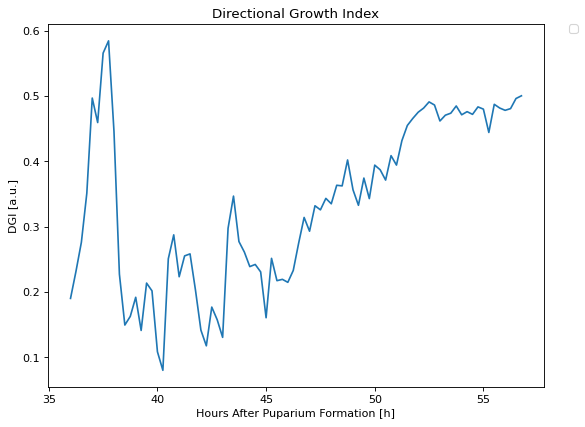

In [ ]:
fig_name = save_path+save_name+'_DGI.pdf'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(output_results.timepoints,output_results.DGI)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Directional Growth Index')
plt.ylabel('DGI [a.u.]')
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig(fig_name, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


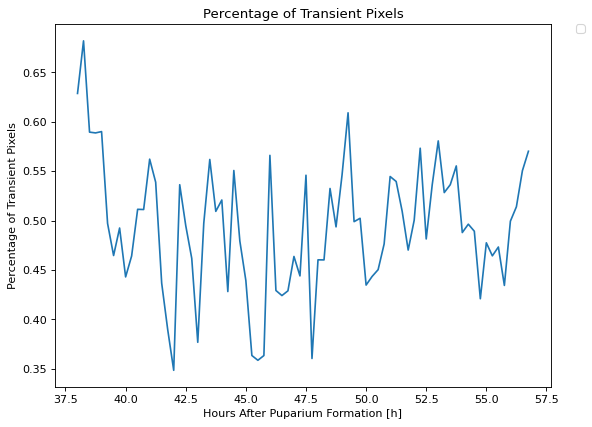

In [13]:
fig_name = save_path+save_name+'_trans_per.pdf'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(output_results.timepoints[8:],output_results.trans_per[8:])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Percentage of Transient Pixels')
plt.ylabel('Percentage of Transient Pixels')
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig(fig_name, bbox_inches='tight')